# Natural Language Processing

## Part 1: TorchText

Let's work on news classification which has four targets: {“World”, “Sports”, “Business”, “Sci/Tech”}.  Also, let's learn about a useful torchtext library which is a library for handling text (aside from gensim, nltk, etc.).

In [1]:
import torch, torchdata, torchtext
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [8]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [9]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [10]:
too_much, train, valid = train.random_split(total_length=train_size, weights = {"too_much": 0.7, "smaller_train": 0.2, "valid": 0.1}, seed=999)

In [11]:
train_size = len(list(iter(train)))
train_size

24000

In [12]:
val_size = len(list(iter(valid)))
val_size

12000

In [13]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [14]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [16]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [18]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [19]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [20]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [21]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [22]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [23]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  Here, in our function, we process the raw text data, and also add padding dynamicaly to match the longest sentences.

In [24]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, batch_first=True)

What is `pad_sequence`?  It's simply padding 0s to make sure every batch has the same length, thus allowing the matrix multiplication to work in bunches.

In [25]:
#let's imagine two sentences in the same batch, but difference length
first_sentence  = [5, 6, 7]
second_sentence = [4, 99]

#convert to torch tensors
first_sentence  = torch.tensor(first_sentence,  dtype=torch.int64)
second_sentence = torch.tensor(second_sentence, dtype=torch.int64)

#append to a list
text_list = []
text_list.append(first_sentence)
text_list.append(second_sentence)

#now let's try pad_sequence
pad_sequence(text_list, batch_first=True) #as you can see it adds 0

tensor([[ 5,  6,  7],
        [ 4, 99,  0]])

Create train, val, and test dataloaders

In [26]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [27]:
for label, text in train_loader:
    break

In [28]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 138])


Note that each batch has different sequence length.

In [29]:
for label, text in train_loader:
    break

print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 163])


Let's look at each sample closely

In [30]:
#let's get only the label of the first sample
label[0]

tensor(3)

In [31]:
#sentence is the second of the two tuple, then we get the sentence of the first sample
sentence = text[0]
sentence

tensor([ 8448, 10182,   352,   914,  6902,    11,    13,   302,    21,   201,
          363,    10,  8448, 10182,     5,    37,   288,     7,   411,   352,
          914,  3527,     5,    27,   579,    11,     9,   883,   261,    12,
           39,   527,   372, 11762,  2642,  2902,  4669,     6,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [32]:
#let's try to look what is this about....
sentence_list = list(sentence)
vocab.lookup_tokens(sentence_list)

['KDE',
 '3.3',
 'Linux',
 'desktop',
 'closes',
 'in',
 'on',
 'Windows',
 'The',
 'final',
 'release',
 'of',
 'KDE',
 '3.3',
 ',',
 'an',
 'open',
 '-',
 'source',
 'Linux',
 'desktop',
 'environment',
 ',',
 'is',
 'due',
 'in',
 'a',
 'few',
 'days',
 'and',
 'will',
 'give',
 'users',
 'greatly',
 'improved',
 'email',
 'facilities',
 '.',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '

## 5. Design the model

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer.

Our RNN takes in sequence of words, $X=\{x_1, ..., x_T\}$, one at a time, and produces a _hidden state_, $h$, for each word. We use the RNN _recurrently_ by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$. 

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros. 

<img src = "figures/sentiment1.png" width="500">

The embedding layer is used to transform our integer into a vector.  Here we gonna create one vector sized 200 for one integer.  Thus the embedding layer shall be <code>nn.Embedding(len(vocab), 200)</code>

### Defining hyperparameters

In [33]:
input_dim = len(vocab)
hidden_dim = 256
embed_dim  = 200
output_dim = 4 #four classes

#training hyperparameters
num_epochs=5
lr=1e-3

### Understanding what is `nn.Embedding`

In [34]:
embedding = nn.Embedding(10, 3)
x = torch.LongTensor([[1,2,4,5],[4,3,2,9]]) #must be long
print("x shape: ", x.shape) # (sent len, batch)
embedded_x = embedding(x)
print("embedded x shape: ", embedded_x.shape) #each integer is now represented by a vector of size 3

x shape:  torch.Size([2, 4])
embedded x shape:  torch.Size([2, 4, 3])


The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_.

`output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1. 

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [35]:
import torch.nn as nn

class simpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc  = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #embedded = [batch size, seq len, embed dim]
        output, hn = self.rnn(embedded)  #if no h0, all zeroes
        
        #output = [batch size, seq len, hidden dim]
        #hidden = [1, batch size, hidden dim]
        
        assert torch.equal(output[:,-1,:], hn.squeeze(0))
        return self.fc(hn.squeeze(0))

In [36]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

In [37]:
w = torch.empty(3, 5)
nn.init.xavier_normal_(w)

tensor([[-0.4348,  0.9342, -1.3126,  0.2844, -0.1851],
        [ 0.8755, -0.4074,  0.1779,  0.2111, -0.0233],
        [ 0.4085,  0.4290, -0.1054,  0.5700, -1.2561]])

In [38]:
model = simpleRNN().to(device)
model.apply(initialize_weights)

simpleRNN(
  (embedding): Embedding(52828, 200)
  (rnn): RNN(200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [39]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

10565600
 51200
 65536
   256
   256
  1024
     4
______
10683876


## 6. Training

In [40]:
import torch.optim as optim

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [41]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [42]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [43]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [44]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [45]:
best_valid_loss = float('inf')

save_path = f'models/{model.__class__.__name__}' #simpleRNN

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 1.395 | Train Acc: 25.98%
	 Val. Loss: 1.391 |  Val. Acc: 24.76%
Epoch: 02 | Train Loss: 1.392 | Train Acc: 24.77%
	 Val. Loss: 1.389 |  Val. Acc: 24.54%
Epoch: 03 | Train Loss: 1.390 | Train Acc: 25.04%
	 Val. Loss: 1.390 |  Val. Acc: 25.62%
Epoch: 04 | Train Loss: 1.390 | Train Acc: 25.86%
	 Val. Loss: 1.393 |  Val. Acc: 25.15%
Epoch: 05 | Train Loss: 1.390 | Train Acc: 26.15%
	 Val. Loss: 1.393 |  Val. Acc: 24.86%


Text(0, 0.5, 'loss')

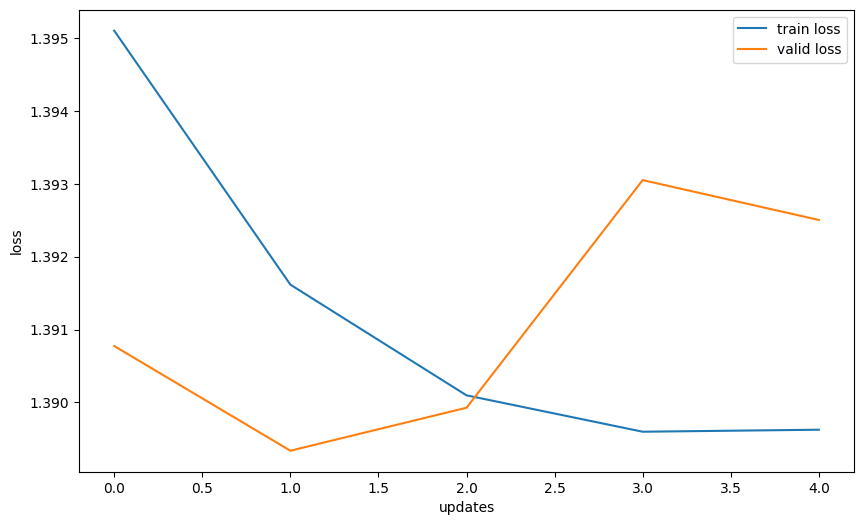

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

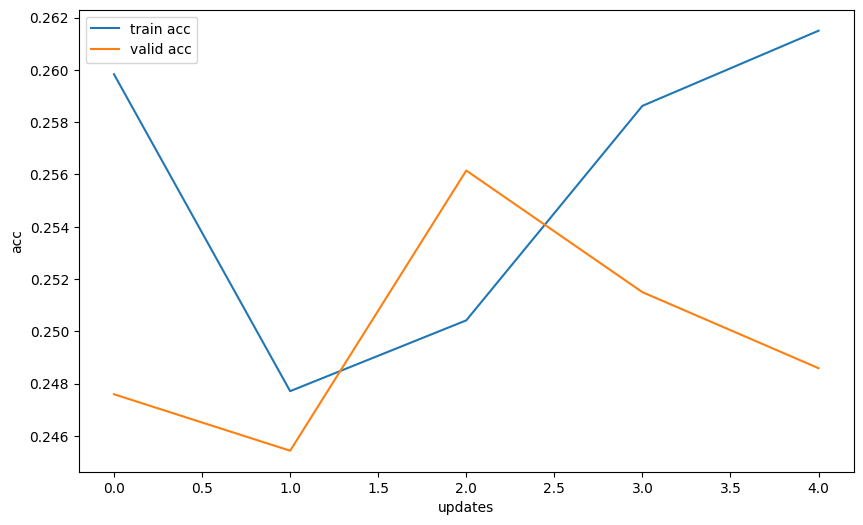

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [48]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.391 | Test Acc: 25.10%


## 7. Test on some random news

In [49]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [50]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [51]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [52]:
text = text.reshape(1, -1)  #because batch_size is 1

In [53]:
text.shape

torch.Size([1, 14])

In [54]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [55]:
predict(text)

tensor([3], device='cuda:0')

## Conclusion

As you can see, we fail terribly.  In the next session, we shall visit some of our critical errors, and fix it!